Generate plots

In [1]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
results_folder = project_folder_path + 'results\\synthetic\\results\\bin_size_runs\\full_signal\\'
fig_folder = project_folder_path + 'results\\synthetic\\figures\\'

In [3]:
save_fig = False

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trails (сoncat)

ACF vs iSTTC, full signal

PearsonR vs iSTTC (concat and avg), trails

In [5]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_full_long_acf_lags_df
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat)')
df_all = pd.read_pickle(results_folder / "summary_tau_full_long_acf_lags_df.pkl")
inspect(df_all, "df_all (all)")

df_isttc_all = pd.read_pickle(results_folder / "summary_tau_full_long_acf_isttc_lags_df.pkl")
inspect(df_isttc_all, "df_isttc_all (all)")

ACF, iSTTC, PersonR, iSTTC trails (сoncat)
len df_all (all): 492235
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'n_lags', 'lv']
len df_isttc_all (all): 492830
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'n_lags', 'lv']


### Prepare extra dataframes for plotting 

In [6]:
# extract the reference tau_ms for n_lags=20
ref = df_all[df_all['n_lags'] == 20][['unit_id', 'tau_ms']]
ref = ref.rename(columns={'tau_ms': 'tau_ms_ref'})

# merge reference back onto the full dataframe
merged = df_all.merge(ref, on='unit_id', how='left')

# compute the difference
merged['tau_ms_diff'] = merged['tau_ms'] - merged['tau_ms_ref']

merged['tau_ms_diff_log10'] = np.log10(np.abs(merged['tau_ms_diff']) + 1)
merged['tau_diff_rel_log10'] = np.log10(merged['tau_diff_rel'])

merged

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,2.217899,2.119224,2.316575,0.998369,True,acf_full,110.894975,600,7.741821,...,150.923515,40.028540,26.522401,0.197350,20,1.307775,110.894975,0.000000,0.000000,1.423613
1,1,2.568210,2.437150,2.699270,0.997899,True,acf_full,128.410512,600,4.394396,...,147.947233,19.536721,13.205195,0.262120,20,1.345006,128.410512,0.000000,0.000000,1.120745
2,2,5.227451,4.334421,6.120482,0.984960,True,acf_full,261.372568,600,8.587393,...,267.002290,5.629722,2.108492,1.786061,20,1.068416,261.372568,0.000000,0.000000,0.323972
3,3,3.950209,2.250084,5.650335,0.889719,True,acf_full,197.510466,600,6.976707,...,194.403797,3.106670,1.598050,3.400250,20,1.055631,197.510466,0.000000,0.000000,0.203590
4,4,3.717963,3.426456,4.009471,0.995737,True,acf_full,185.898174,600,0.950832,...,239.986489,54.088315,22.538067,0.583014,20,1.357205,185.898174,0.000000,0.000000,1.352917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492230,99994,4.475841,3.973274,4.978407,0.995573,True,acf_full,268.550442,600,6.938018,...,239.402724,29.147718,12.175182,1.005133,16,1.136797,264.990762,3.559680,0.658934,1.085475
492231,99995,1.733853,1.109046,2.358661,0.929727,True,acf_full,104.031199,600,2.672839,...,125.243251,21.212051,16.936682,1.249615,16,1.178739,111.382499,-7.351300,0.921754,1.228828
492232,99996,1.391714,1.303135,1.480294,0.997707,True,acf_full,83.502854,600,5.754497,...,94.481295,10.978440,11.619697,0.177159,16,1.353800,87.281338,-3.778484,0.679290,1.065195
492233,99997,2.321685,1.379654,3.263715,0.915569,True,acf_full,139.301076,600,5.604441,...,174.189672,34.888597,20.029084,1.884061,16,1.064661,149.742178,-10.441102,1.058468,1.301661


In [7]:
# extract the reference tau_ms for n_lags=20
ref = df_isttc_all[df_isttc_all['n_lags'] == 20][['unit_id', 'tau_ms']]
ref = ref.rename(columns={'tau_ms': 'tau_ms_ref'})

# merge reference back onto the full dataframe
merged_isttc = df_isttc_all.merge(ref, on='unit_id', how='left')

# compute the difference
merged_isttc['tau_ms_diff'] = merged_isttc['tau_ms'] - merged_isttc['tau_ms_ref']

merged_isttc['tau_ms_diff_log10'] = np.log10(np.abs(merged_isttc['tau_ms_diff']) + 1)
merged_isttc['tau_diff_rel_log10'] = np.log10(merged_isttc['tau_diff_rel'])

merged_isttc

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,2.523412,2.362379,2.684445,0.996707,True,acf_isttc_full,126.170618,600,7.741821,...,150.923515,24.752897,16.400954,0.322066,20,1.307775,126.170618,0.000000,0.000000,1.214869
1,1,2.834326,2.688470,2.980182,0.997916,True,acf_isttc_full,141.716309,600,4.394396,...,147.947233,6.230924,4.211585,0.291712,20,1.345006,141.716309,0.000000,0.000000,0.624446
2,2,4.855442,4.132395,5.578488,0.987654,True,acf_isttc_full,242.772076,600,8.587393,...,267.002290,24.230214,9.074909,1.446094,20,1.068416,242.772076,0.000000,0.000000,0.957842
3,3,4.460909,2.176731,6.745087,0.862334,True,acf_isttc_full,223.045437,600,6.976707,...,194.403797,28.641641,14.733066,4.568356,20,1.055631,223.045437,0.000000,0.000000,1.168293
4,4,4.609823,4.280359,4.939287,0.996987,True,acf_isttc_full,230.491166,600,0.950832,...,239.986489,9.495323,3.956607,0.658928,20,1.357205,230.491166,0.000000,0.000000,0.597323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492825,99994,4.208232,3.726986,4.689477,0.995091,True,acf_isttc_full,252.493901,600,6.938018,...,239.402724,13.091177,5.468266,0.962491,16,1.136797,254.250387,-1.756486,0.440356,0.737850
492826,99995,1.447119,0.940293,1.953945,0.934463,True,acf_isttc_full,86.827116,600,2.672839,...,125.243251,38.416135,30.673217,1.013652,16,1.178739,99.306590,-12.479474,1.129673,1.486759
492827,99996,1.341132,1.207330,1.474935,0.994434,True,acf_isttc_full,80.467938,600,5.754497,...,94.481295,14.013357,14.831885,0.267605,16,1.353800,82.286403,-1.818465,0.450013,1.171196
492828,99997,2.466711,1.447070,3.486352,0.914202,True,acf_isttc_full,148.002661,600,5.604441,...,174.189672,26.187012,15.033619,2.039283,16,1.064661,145.325980,2.676680,0.565456,1.177064


### Plots

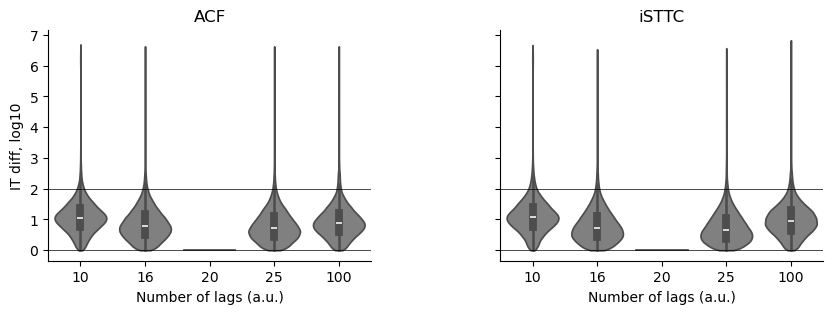

In [10]:
color = 'gray'

fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(x='n_lags', y='tau_ms_diff_log10', data=merged , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[0])
axes[0].set_title('ACF')

sns.violinplot(x='n_lags', y='tau_ms_diff_log10', data=merged_isttc , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[1])
axes[1].set_title('iSTTC')

#axes.set_xticklabels(['10', '20\n(reference)', '100'])

for ax in axes:
    ax.set_ylabel('IT diff, log10')
    ax.set_xlabel('Number of lags (a.u.)')
    ax.axhline(y=2, lw=0.5, c='k')
    ax.axhline(y=0, lw=0.5, c='k')
    sns.despine(ax=ax)

# if save_fig:
#     plt.savefig(fig_folder + 'isttc_concat_zeros.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'isttc_concat_zeros.svg' , bbox_inches='tight')

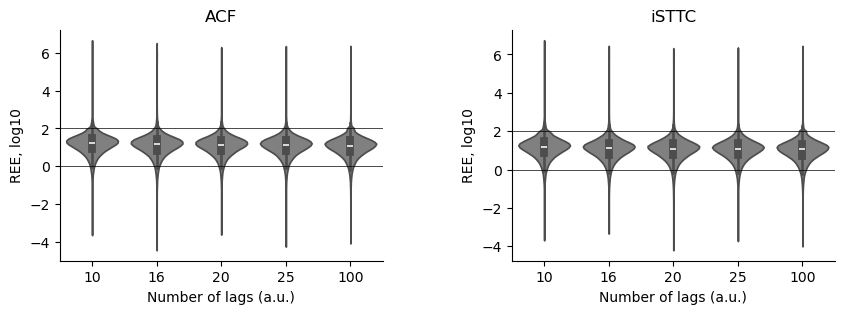

In [11]:
# color = 'gray'

# fig, axes = plt.subplots(1,2, figsize=(10,3))
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

# sns.violinplot(x='n_lags', y='tau_diff_rel_log10', data=merged , cut=0, density_norm='width', 
#                legend=False, color=color, ax=axes[0])
# axes[0].set_title('ACF')

# sns.violinplot(x='n_lags', y='tau_diff_rel_log10', data=merged_isttc , cut=0, density_norm='width', 
#                legend=False, color=color, ax=axes[1])
# axes[1].set_title('iSTTC')

# for ax in axes.flat:
#     ax.axhline(y=2, lw=0.5, c='k')
#     ax.axhline(y=0, lw=0.5, c='k')
#     ax.set_ylabel('REE, log10')
#     ax.set_xlabel('Number of lags (a.u.)')
#     sns.despine(ax=ax)